In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import math
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from sklearn.metrics import r2_score

In [2]:
#Function to convert GPS time to milliseconds
#The base time is the RTC time in milliseconds that corresponds with the first GPS time stamp
def timeToMillis(time, RTC_millis):
    sec = np.zeros(time.size)
    sec = sec.astype(int)
    minutes = np.zeros(time.size)
    minutes = minutes.astype(int)
    hours = np.zeros(time.size)
    hours = hours.astype(int)
    for i in range(0, time.size):
        sec[i] = time[i]%100
    for i in range(0, time.size):
        minutes[i] = (time[i]%10000 - time[i]%100)/100
    for i in range(0, time.size):
        hours[i] = (time[i] - time[i]%10000)/10000

    GPS_millis = np.zeros(time.size)
    GPS_millis = GPS_millis.astype(int)
    GPS_millis[0] = RTC_millis[0]
    for i in range (1, time.size):
        if (sec[i] > sec[i - 1]):
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1])*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (sec[i] - sec[i - 1])*1000 + (60 + minutes[i] - minutes[i - 1])*60*1000            
        else:
            if (minutes[i] >= minutes[i - 1]):
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (minutes[i] - minutes[i - 1] - 1)*60*1000
            else:
                GPS_millis[i] = GPS_millis[i - 1] + (60 + sec[i] - sec[i - 1])*1000 + (59 + minutes[i] - minutes[i - 1])*60*1000            
    return GPS_millis


#Function to convert time in milliseconds to digital time 
#Used to convert both GPS time in milliseconds and RTC time in milliseconds to digital time 
#The base time is taken as the first GPS time stamp
def millisToTime(millis, time):
    mil = millis/1000
    time_temp = np.zeros(time.size)
    hours = np.zeros(time_temp.size)
    minutes = np.zeros(time_temp.size)
    seconds = np.zeros(time_temp.size)
    time_temp[0] = time[0]
    for i in range (1, time.size):
        seconds[i] = time_temp[i - 1]%100 + (mil[i] - mil[i - 1])
        if (seconds[i] > 60):
            temp_minutes = 0
            while (seconds[i] >= 60):
                temp_minutes += 100
                seconds[i] = seconds[i] - 60
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + temp_minutes
        elif (seconds[i] == 60):
            seconds[i] = 0
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100) + 100
        else:
            minutes[i] = (time_temp[i-1]%10000 - time_temp[i-1]%100)
        if (minutes[i] > 5900):
            minutes[i] = 6000 - minutes[i]
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000) + 10000
        else:
            hours[i] = (time_temp[i-1] - time_temp[i-1]%10000)
        if (hours[i] > 230000):
            hours[i] = 240000 - hours[i]
        time_temp[i] = hours[i] + minutes[i] + seconds[i]

    #Split time with colons
    output_time = [0 for i in range(time_temp.size)]
    hours_temp = np.zeros(time_temp.size)
    minutes_temp = np.zeros(time_temp.size)
    seconds_temp = np.zeros(time_temp.size)
    for i in range (0, time_temp.size):
        hours_temp[i] = int((time_temp[i] - time_temp[i]%10000)/10000)
        minutes_temp[i] = int((time_temp[i]%10000 - time_temp[i]%100)/100)
        seconds_temp[i] = time_temp[i]%100
        if (seconds_temp[i] < 10):
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
            else:
                output_time[i] = "%d:%d:0%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
        else:
            if(minutes_temp[i] < 10):
                output_time[i] = "%d:0%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])  
            else:
                output_time[i] = "%d:%d:%.3f" % (hours_temp[i], minutes_temp[i], seconds_temp[i])
    return output_time 

#Split data into training and testing sets (0.8/0.2)
def dataSplit(x_millis, y_millis):
    x_train, x_test, y_train, y_test = train_test_split(x_millis, y_millis, test_size=0.2, random_state=1)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 1)
    return x_train.reshape(-1,1), y_train.reshape(-1,1), x_test.reshape(-1,1), y_test.reshape(-1,1), x_val.reshape(-1,1), y_val.reshape(-1,1)


#Metrics for regression analysis
def RMSE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = (y[i] - predict[i])**2
    return np.sqrt((np.sum(c))/len(c))

def MAE(predict, y):
    c = np.zeros(predict.size)
    for i in range (0, predict.size):
        c[i] = abs(y[i] - predict[i])
    return (np.sum(c))/len(c)

#Metrics related to clock AccOffset 
def plotDrift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    t = np.linspace(50000, len(GPS_millis[50000:len(GPS_millis)]), len(GPS_millis[50000:len(GPS_millis)]))
    plt.plot(t, Drift[50000:len(GPS_millis)])
    plt.title('Frequency of clock drift of Teensy internal RTC (ppm)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Drift (ppm)')
    plt.show()

def plotOffset(GPS_millis, RTC_millis):
    offset = np.zeros(GPS_millis.size)
    offsetsum = 0
    for i in range(0, GPS_millis.size):
        offset[i] = (GPS_millis[i] - offsetsum - RTC_millis[i])
        offsetsum = np.sum(offset)
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, offset)
    plt.title('Clock offset of internal Teensy RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Clock offset (ms)')
    plt.show()
    

def plotAccOffset(GPS_millis, RTC_millis):
    AccOffset = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        AccOffset[i] = (GPS_millis[i] - RTC_millis[i])
    t = np.linspace(0, len(GPS_millis), len(GPS_millis))
    plt.plot(t, AccOffset)
    plt.title('Accumulated offset of Teensy internal RTC (ms)')
    plt.xlabel('Seconds since start-up')
    plt.ylabel('Accumulated offset (ms)')
    plt.show()
    
def AccOffset(GPS_millis, RTC_millis):
    d = np.zeros(GPS_millis.size)
    for i in range(0, GPS_millis.size):
        d[i] = (GPS_millis[i] - RTC_millis[i])
    return d

def Drift(GPS_millis, RTC_millis):
    Drift = np.zeros(GPS_millis.size)
    for i in range(1, GPS_millis.size):
        Drift[i] = ((GPS_millis[i] - RTC_millis[i])/GPS_millis[i])*1000000
    return Drift

def convertToCycles(array):
    a = np.zeros(array.size)
    for i in range(0, array.size):
        a[i] = (array[i]/1000)*32768
    return a

#dataframe to summarise linear regression metrics
def RegMetrics(x1_train, y1_train, x1_val, y1_val, x1_test, y1_test, model):
    predict1 = model.predict(x1_train)
    r1 =  model.score(x1_train, y1_train)
    rmse1 = RMSE(predict1, y1_train)
    mae1 =  MAE(predict1, y1_train)
    
    predict2 = model.predict(x1_test)
    r2 = model.score(x1_test, y1_test)
    rmse2 = RMSE(predict2, y1_test)
    mae2 = MAE(predict2, y1_test)
    
    predict3 = model.predict(x1_val)
    r3 = model.score(x1_val, y1_val)
    rmse3 = RMSE(predict3, y1_val)
    mae3 = MAE(predict3, y1_val)
    
    d = {'Index Title': ['Training', 'Validation', 'Test'],'R': [r1, r3, r2], 'RMSE' : [rmse1, rmse3, rmse2], 'MAE' :[mae1, mae3, mae2]}
    df = pd.DataFrame(d).set_index('Index Title')
    return display(df)


#Data Frames to summarise metrics for testing sets and display synchronised time
def synch(input_vector, RTC_millis, GPS_millis, model, time, drift):
    millis_predict = model.predict(input_vector)
    #Convert drift prediction to synchronised time by adding the drift to RTC time in milliseconds
    for i in range (0, millis_predict.size):
        millis_predict[i] = RTC_millis[i] + millis_predict[i]
    millis_predict = (np.reshape(millis_predict, len(millis_predict))).astype(int)
    rmse =  RMSE(millis_predict, GPS_millis)
    mae = MAE(millis_predict, GPS_millis)
    
    d = {'RMSE' : [rmse], 'MAE' :[mae]}
    d = pd.DataFrame(d)
    display(d)
    df = pd.DataFrame({'GPS Time (ms)': GPS_millis, 'RTC Time (ms)': RTC_millis, 
                         'Synch Time (ms)' : millis_predict, 'GPS Time': millisToTime(GPS_millis, time),
                            'RTC Time':millisToTime(RTC_millis, time), 'Synch Time' : millisToTime(millis_predict, time)})
    display(df)

In [3]:
#Reading data from training run of sensor 1
with open('DS3231.TXT', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open('DS3231.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('GPS/RTC', 'Time', 'Day', 'Month', 'Year', 'Millis', 'Temp', 'Offset', 'Number'))
        writer.writerows(lines)
        
data1 = pd.read_csv("DS3231.csv")
data_arr1 = np.array(data1)
time1 = data_arr1[0:,1]
#RTC_millis1 = data_arr1[0:,5]
temp1 = data_arr1[0:,6]
offset1 = data_arr1[0:,7]
num1 = data_arr1[0:,8]

RTC_millis1 = np.zeros(offset1.size)
for i in range(0, offset1.size):
    RTC_millis1[i] = offset1[i] + RTC_millis1[i - 1]
for i in range(0, offset1.size):
    RTC_millis1[i] = (RTC_millis1[i]/32768)*1000

In [4]:
#Determining the GPS milliseconds since start-up for all three sensors
GPS_millis1 = timeToMillis(time1, RTC_millis1)

#Determining the AccOffset of all three sensors
AccOffset1 = AccOffset(GPS_millis1, RTC_millis1)

#Creating input vector from RTC milliseconds and temperature arrays
x1 = pd.DataFrame({'RTC_millis1': RTC_millis1, 'temp1': temp1, 'AccOffset1': AccOffset1})

X1 = pd.concat([x1["RTC_millis1"],x1["temp1"]], axis = 1)

#Splitting the training and testing data 
train1_rand = x1.sample(frac=0.8, random_state=1)
test1 = x1.drop(train1_rand.index)
test1_rand = test1.sample(frac = 0.5, random_state = 1)
val1 = test1.drop(test1_rand.index)
val1_rand = val1.sample(frac = 0.5, random_state = 1)

x1_train = pd.concat([train1_rand["RTC_millis1"],train1_rand["temp1"]], axis = 1)
y1_train = pd.concat([train1_rand["AccOffset1"]], axis = 1)

x1_test = pd.concat([test1_rand["RTC_millis1"],test1_rand["temp1"]], axis = 1)
y1_test = pd.concat([test1_rand["AccOffset1"]], axis = 1)

x1_val = pd.concat([val1_rand["RTC_millis1"],val1_rand["temp1"]], axis = 1)
y1_val = pd.concat([val1_rand["AccOffset1"]], axis = 1)

In [17]:
#TensorFlow linear regression training and validation
normalizer1 = preprocessing.Normalization()
normalizer1.adapt(np.array(x1_train))

model3 = tf.keras.Sequential([
    normalizer1,
    layers.Dense(units=1)
])

model3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#history1 = model3.fit(
#    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
#    epochs = 8,
#    verbose = 1
#    )

In [18]:
error = np.zeros(8)
for i in range(1, 9):
    history1 = model3.fit( 
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    epochs = i,
    verbose = 1
    )
    predict = model3.predict(np.array(x1_val).astype(float))
    error[i - 1] = RMSE(predict, np.array(y1_val))
    

Train on 194922 samples
194922/194922 [==============================] - 6s 31us/sample - loss: 3.5484
Train on 194922 samples
Epoch 1/2
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2069
Epoch 2/2
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2077
Train on 194922 samples
Epoch 1/3
194922/194922 [==============================] - 6s 30us/sample - loss: 1.2076
Epoch 2/3
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2072
Epoch 3/3
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2078
Train on 194922 samples
Epoch 1/4
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2071
Epoch 2/4
194922/194922 [==============================] - 6s 29us/sample - loss: 1.20820s - loss: 1.20
Epoch 3/4
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2080
Epoch 4/4
194922/194922 [==============================] - 6s 32us/sample - loss: 1.2082 - ETA: 3s

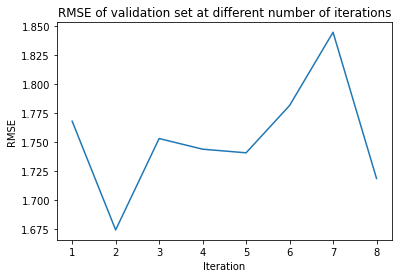

[1.76786545 1.67403909 1.75293872 1.74373317 1.74059759 1.78142363
 1.84468608 1.7184377 ]


In [19]:
t = np.linspace(1, 8, 8)
plt.plot(t, error)
plt.title('RMSE of validation set at different number of iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()
print(error)

In [20]:
history1 = model3.fit( 
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    epochs = 2,
    verbose = 1
    )

Train on 194922 samples
Epoch 1/2
194922/194922 [==============================] - 6s 29us/sample - loss: 1.20750
Epoch 2/2
194922/194922 [==============================] - 6s 29us/sample - loss: 1.2074


In [23]:
#Metrics for linear regression
predict = model3.predict(np.array(x1_train).astype(float))
print(MAE(predict, np.array(y1_train)))
print(RMSE(predict, np.array(y1_train)))
print(r2_score(predict, np.array(y1_train)))

predict = model3.predict(np.array(x1_val).astype(float))
print(MAE(predict, np.array(y1_val)))
print(RMSE(predict, np.array(y1_val)))
print(r2_score(predict, np.array(y1_val)))

predict = model3.predict(np.array(x1_test).astype(float))
print(MAE(predict, np.array(y1_test)))
print(RMSE(predict, np.array(y1_test)))
print(r2_score(predict, np.array(y1_test)))


#predict2 = model3.predict(np.array(X2).astype(float))
#print(MAE(predict2, np.array(AccOffset2)))
#print(RMSE(predict2, np.array(AccOffset2)))
#print(r2_score(predict2, np.array(AccOffset2)))


1.1998702223226247
1.7504983041087385
0.9966632064690492
1.224706836412975
1.7784966697814506
0.9964992207342469
1.2042940216095765
1.7570314207839652
0.9966349088129411


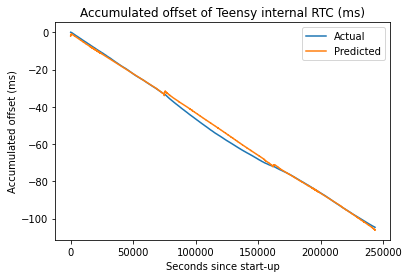

In [24]:
#Predicted vs actual, linear regression, training data 
prediction = model3.predict(np.array(X1).astype(float))
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, AccOffset1, label = 'Actual')
plt.plot(t, prediction, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()



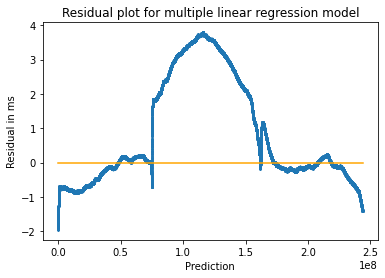

In [25]:
#Residuals, linear regression, training data 
predictRes = model3.predict(np.array(X1).astype(float))
AccOffset1 = np.array(AccOffset1)
X1 = np.array(X1)
resid2 = np.zeros(AccOffset1.size)
for i in range(0, AccOffset1.size):
    resid2[i] = predictRes[i] - AccOffset1[i]
#Residual plots
t = np.linspace(0,max(X1[0:,0]))
z = np.zeros(50)
plt.scatter(X1[0:,0], resid2, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for multiple linear regression model')
plt.xlabel('Prediction')
plt.ylabel('Residual in ms')
plt.show()

In [26]:
#Tensor flow neural network training and validation

normalizer1 = preprocessing.Normalization()
normalizer1.adapt(np.array(x1_train))

def build_and_compile_model(norm, i):
  model = keras.Sequential([
      norm,
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(40, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1/(10**i)))
  return model

#net2 = build_and_compile_model(normalizer1)

#history2 = net2.fit(
#    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
#    verbose=1, epochs=8)


In [27]:
error2 = np.zeros(8)
for i in range(1, 9):
    net2 = build_and_compile_model(normalizer1, i)
    history2 = net2.fit(
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    verbose=1, epochs=5)
    predict_net = net2.predict(np.array(x1_val).astype(float))
    error2[i - 1] = RMSE(predict_net, np.array(y1_val))

Train on 194922 samples
Epoch 1/5
194922/194922 [==============================] - 7s 38us/sample - loss: 1.1037 - ETA: 6s - loss: - ETA: 5s - loss: 1. - ETA: 5s - loss: 1. - E
Epoch 2/5
194922/194922 [==============================] - 7s 38us/sample - loss: 0.6386
Epoch 3/5
194922/194922 [==============================] - 7s 37us/sample - loss: 0.51100s - loss - ETA: 0s - 
Epoch 4/5
194922/194922 [==============================] - 7s 37us/sample - loss: 0.44316s - loss - ETA: 4s - - - ETA: 0s - loss: 0.
Epoch 5/5
194922/194922 [==============================] - 7s 38us/sample - loss: 0.39271s - loss: 0.39 -
Train on 194922 samples
Epoch 1/5
194922/194922 [==============================] - 8s 42us/sample - loss: 1.04500s - loss: 1.
Epoch 2/5
194922/194922 [==============================] - 8s 42us/sample - loss: 0.1530
Epoch 3/5
194922/194922 [==============================] - 8s 41us/sample - loss: 0.1468
Epoch 4/5
194922/194922 [==============================] - 8s 42us/sample - loss

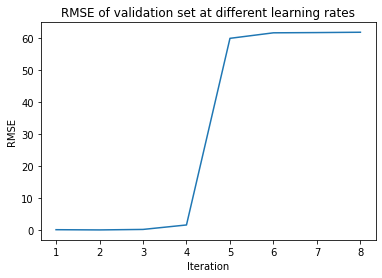

[ 0.19525595  0.12752578  0.27849104  1.66958381 59.81002699 61.52851812
 61.60246253 61.70690354]


In [28]:
t = np.linspace(1, 8, 8)
plt.plot(t, error2)
plt.title('RMSE of validation set at different learning rates')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()
print(error2)

In [29]:
error3 = np.zeros(8)
for i in range(1, 9):
    net2 = build_and_compile_model(normalizer1,2)
    history2 = net2.fit(
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    verbose=1, epochs=i)
    predict_net2 = net2.predict(np.array(x1_val).astype(float))
    error3[i - 1] = RMSE(predict_net2, np.array(y1_val))

Train on 194922 samples
194922/194922 [==============================] - 8s 39us/sample - loss: 1.04385s - loss: 3. - ETA: 5s -  - ETA: 3s - l
Train on 194922 samples
Epoch 1/2
194922/194922 [==============================] - 8s 39us/sample - loss: 1.0503
Epoch 2/2
194922/194922 [==============================] - 7s 38us/sample - loss: 0.1557 - ETA: 3s  - ETA: 2s - loss: 0 - ETA: 2s - lo - ETA: 1s - loss:  - ETA: 1s - los - ETA: 0
Train on 194922 samples
Epoch 1/3
194922/194922 [==============================] - 8s 40us/sample - loss: 1.0856: 1  - ETA: 4s - l - ETA: 3s - loss: 1. - ETA: 3 - ETA: 2 - ETA: 1s - loss: 1. - ETA: 1s - los - ETA: 0
Epoch 2/3
194922/194922 [==============================] - 8s 39us/sample - loss: 0.14050s 
Epoch 3/3
194922/194922 [==============================] - 8s 42us/sample - loss: 0.1413
Train on 194922 samples
Epoch 1/4
194922/194922 [==============================] - 9s 46us/sample - loss: 1.0065
Epoch 2/4
194922/194922 [==============================

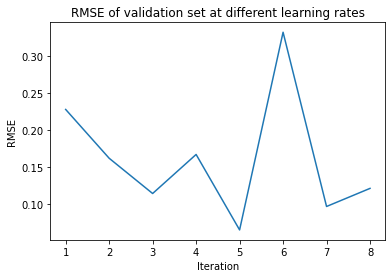

[0.22779927 0.16174061 0.11398751 0.16685402 0.06468824 0.33233298
 0.09642221 0.1209269 ]


In [30]:
t = np.linspace(1, 8, 8)
plt.plot(t, error3)
plt.title('RMSE of validation set at different iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.show()
print(error3)

In [31]:
net2 = build_and_compile_model(normalizer1, 2)

history2 = net2.fit(
    np.array(x1_train).astype(float), np.array(y1_train).astype(float),
    verbose=1, epochs=5)

Train on 194922 samples
Epoch 1/5
194922/194922 [==============================] - 7s 38us/sample - loss: 0.99201s - l
Epoch 2/5
194922/194922 [==============================] - 7s 37us/sample - loss: 0.1629
Epoch 3/5
194922/194922 [==============================] - 7s 37us/sample - loss: 0.15482s  - ETA: 0s - loss
Epoch 4/5
194922/194922 [==============================] - 7s 38us/sample - loss: 0.15871s - loss: 0. - ETA: 1s - loss: 0.160 
Epoch 5/5
194922/194922 [==============================] - 7s 37us/sample - loss: 0.1481 - E


In [32]:
#Metrics for neural network 
predict1 = net2.predict(np.array(x1_train).astype(float))
print(MAE(predict1, np.array(y1_train)))
print(RMSE(predict1, np.array(y1_train)))
print(r2_score(predict1, np.array(y1_train)))


predict3 = net2.predict(np.array(x1_val).astype(float))
print(MAE(predict3, np.array(y1_val)))
print(RMSE(predict3, np.array(y1_val)))
print(r2_score(predict3, np.array(y1_val)))


predict4 = net2.predict(np.array(x1_test).astype(float))
print(MAE(predict4, np.array(y1_test)))
print(RMSE(predict4, np.array(y1_test)))
print(r2_score(predict4, np.array(y1_test)))


0.1794643642926874
0.19957165887727188
0.9999568126916158
0.17839478536341857
0.1985879451704185
0.9999565744689349
0.17962750508607644
0.19988418150952145
0.9999566267211393


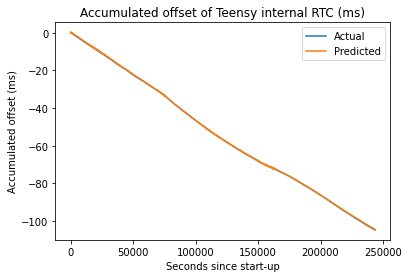

In [34]:
#Predicted vs actual, neural network, training data 
prediction2 = net2.predict(np.array(X1).astype(float))
t = np.linspace(0, len(GPS_millis1), len(GPS_millis1))
plt.plot(t, AccOffset1, label = 'Actual')
plt.plot(t, prediction2, label = 'Predicted')
plt.title('Accumulated offset of Teensy internal RTC (ms)')
plt.xlabel('Seconds since start-up')
plt.ylabel('Accumulated offset (ms)')
plt.legend()
plt.show()

In [11]:
print("Time Synchronisation Results Using Neural Net")
synch(np.array(X1).astype(float), RTC_millis1, GPS_millis1, net2, time1, AccOffset1)
print("Time Synchronisation Results Using Linear Regression")
synch(np.array(X1).astype(float), RTC_millis1, GPS_millis1, model3, time1, AccOffset1)


Time Synchronisation Results Using Neural Net


,RMSE,MAE
0,3.825513,1.835766


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,998,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,1998,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,2998,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,3998,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,4998,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243686000,6:53:54.000,6:53:54.105,6:53:54.002
243648,243687000,2.436871e+08,243686992,6:53:55.000,6:53:55.105,6:53:54.994
243649,243688000,2.436881e+08,243688000,6:53:56.000,6:53:56.105,6:53:56.002
243650,243689000,2.436891e+08,243688992,6:53:57.000,6:53:57.105,6:53:56.994


Time Synchronisation Results Using Linear Regression


,RMSE,MAE
0,4.827932,2.845398


,GPS Time (ms),RTC Time (ms),Synch Time (ms),GPS Time,RTC Time,Synch Time
0,1000,1.000000e+03,998,11:12:29.000,11:12:29.000,11:12:29.000
1,2000,2.000000e+03,1998,11:12:30.000,11:12:30.000,11:12:30.000
2,3000,3.000000e+03,2998,11:12:31.000,11:12:31.000,11:12:31.000
3,4000,4.000000e+03,3998,11:12:32.000,11:12:32.000,11:12:32.000
4,5000,5.000000e+03,4998,11:12:33.000,11:12:33.000,11:12:33.000
...,...,...,...,...,...,...
243647,243686000,2.436861e+08,243686000,6:53:54.000,6:53:54.105,6:53:54.002
243648,243687000,2.436871e+08,243686992,6:53:55.000,6:53:55.105,6:53:54.994
243649,243688000,2.436881e+08,243688000,6:53:56.000,6:53:56.105,6:53:56.002
243650,243689000,2.436891e+08,243688992,6:53:57.000,6:53:57.105,6:53:56.994


In [12]:
#Calculation of VIF of input matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1.values.astype(float), i) for i in range(X1.astype(float).shape[1])]
vif["features"] = X1.columns
display(vif)

C:\Users\suben\AppData\Roaming\Python\Python37\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


,VIF Factor,features
0,5.520195,RTC_millis1
1,5.520195,temp1


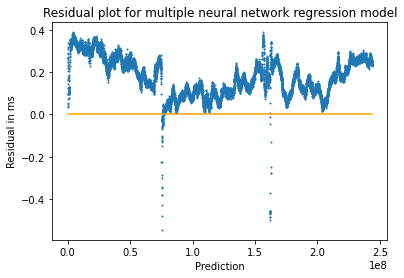

In [35]:
#Residuals, neural network, training data 
predict1 = net2.predict(np.array(x1_val).astype(float))
y1_val = np.array(y1_val)
x1_val = np.array(x1_val)
resid1 = np.zeros(y1_val.size)
for i in range(0, y1_val.size):
    resid1[i] = predict1[i] - y1_val[i]
#Residual plots
t = np.linspace(0,max(x1_val[0:,0]))
z = np.zeros(50)
plt.scatter(x1_val[0:,0], resid1, s = 1)
plt.plot(t, z, color = 'orange')
plt.title('Residual plot for multiple neural network regression model')
plt.xlabel('Prediction')
plt.ylabel('Residual in ms')
plt.show()